<a href="https://colab.research.google.com/github/drywantonmee/Databusters/blob/main/NUS_DSESC_DATABUSTERS_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Overview

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Load the datasets
monthly_data_path = "Monthly Data.csv"
quarterly_data_path = "Quarterly Data.csv"

# Read CSV files
quarterly_data = pd.read_csv(quarterly_data_path)
monthly_data = pd.read_csv(monthly_data_path)

# Check For Missing Data

In [24]:
# Check for missing values in each dataset
missing_quarterly = quarterly_data.isnull().sum().sum()
missing_monthly = monthly_data.isnull().sum().sum()

# Check the data types and missing values for key variables in quarterly data
missing_summary_quarterly = quarterly_data.isnull().sum().sort_values(ascending=False).head(10)
missing_summary_monthly = monthly_data.isnull().sum().sort_values(ascending=False).head(10)

missing_quarterly, missing_monthly, missing_summary_quarterly, missing_summary_monthly

(3024,
 946,
 TWEXAFEGSMTHx    188
 SPCS20RSA        164
 EXUSEU           160
 CP3M             152
 COMPAPFF         152
 CPF3MTB3Mx       152
 RSAFSx           132
 ACOGNOx          132
 COMPRMS          112
 OPHMFG           112
 dtype: int64,
 ACOGNO           399
 TWEXAFEGSMTHx    168
 UMCSENTx         154
 ANDENOx          109
 VIXCLSx           42
 PERMITNE          12
 PERMITMW          12
 PERMITS           12
 PERMITW           12
 PERMIT            12
 dtype: int64)

# Data Cleaning

In [25]:
# Drop columns with more than 30% missing values
threshold_quarterly = int(0.3 * len(quarterly_data))
threshold_monthly = int(0.3 * len(monthly_data))

quarterly_data_clean = quarterly_data.dropna(axis=1, thresh=threshold_quarterly)
monthly_data_clean = monthly_data.dropna(axis=1, thresh=threshold_monthly)

# Forward fill cells with missing data
quarterly_data_clean.fillna(method="ffill", inplace=True)
monthly_data_clean.fillna(method="ffill", inplace=True)

# Define the target variable: Economic Contraction
quarterly_data_clean["GDP_Growth"] = quarterly_data_clean["GDPC1"].pct_change() * 100
quarterly_data_clean["Economic_Contraction"] = (quarterly_data_clean["GDP_Growth"] < 0).astype(int)

# Drop first row with NaN GDP growth
quarterly_data_clean = quarterly_data_clean.dropna(subset=["GDP_Growth"])

<ipython-input-25-ddbd697e12d0>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  quarterly_data_clean.fillna(method="ffill", inplace=True)
<ipython-input-25-ddbd697e12d0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarterly_data_clean.fillna(method="ffill", inplace=True)
<ipython-input-25-ddbd697e12d0>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data_clean.fillna(method="ffill", inplace=True)


# Feature Selection

In [26]:
# Select Key Features
selected_features = [
    "GDPC1",  # Real GDP
    "PCECC96",  # Personal Consumption
    "GPDIC1",  # Gross Private Domestic Investment
    "CNCFx",  # Consumer Confidence Index
    "S&P 500",  # Stock Market Index
    "S&P PE ratio",  # Market Valuation Indicator
    "UMCSENTx",  # Consumer Sentiment
    "INDPRO",  # Industrial Production Index
    "PAYEMS",  # Total Nonfarm Payrolls
    "CPIAUCSL",  # Consumer Price Index
    "GDP_Growth",  # GDP Growth Rate
]

# Subset the data
model_data = quarterly_data_clean[selected_features + ["Economic_Contraction"]].dropna()

# 80-20 train-test split
from sklearn.model_selection import train_test_split

X = model_data.drop(columns=["Economic_Contraction"])
y = model_data["Economic_Contraction"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# Random Forest with Under Sampling
from sklearn.utils import resample

# Combine X_train and y_train for resampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data["Economic_Contraction"] == 0]
minority_class = train_data[train_data["Economic_Contraction"] == 1]

# Downsample majority class
majority_downsampled = resample(majority_class, replace=False,
                                 n_samples=len(minority_class), random_state=42)

# Combine downsampled majority class with minority class
balanced_train_data = pd.concat([majority_downsampled, minority_class])

# Split again into features and labels
X_train_balanced = balanced_train_data.drop(columns=["Economic_Contraction"])
y_train_balanced = balanced_train_data["Economic_Contraction"]

# Train a Random Forest model on balanced data
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_rf_balanced = rf_model_balanced.predict(X_test)

# Evaluate model performance
accuracy_rf_balanced = accuracy_score(y_test, y_pred_rf_balanced)
conf_matrix_rf_balanced = confusion_matrix(y_test, y_pred_rf_balanced)
classification_rep_rf_balanced = classification_report(y_test, y_pred_rf_balanced)

accuracy_rf_balanced, conf_matrix_rf_balanced, classification_rep_rf_balanced

# Replace infinite values with NaN and drop them
model_data_cleaned = model_data.replace([np.inf, -np.inf], np.nan).dropna()

# Re-split the cleaned dataset
X = model_data_cleaned.drop(columns=["Economic_Contraction"])
y = model_data_cleaned["Economic_Contraction"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a logistic regression model for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions
y_pred = log_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, conf_matrix, classification_rep

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9056603773584906,
 array([[47,  0],
        [ 5,  1]]),
 '              precision    recall  f1-score   support\n\n           0       0.90      1.00      0.95        47\n           1       1.00      0.17      0.29         6\n\n    accuracy                           0.91        53\n   macro avg       0.95      0.58      0.62        53\nweighted avg       0.91      0.91      0.87        53\n')

In [28]:
# Re-import necessary library
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model on balanced data
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_rf_balanced = rf_model_balanced.predict(X_test)

# Evaluate model performance
accuracy_rf_balanced = accuracy_score(y_test, y_pred_rf_balanced)
conf_matrix_rf_balanced = confusion_matrix(y_test, y_pred_rf_balanced)
classification_rep_rf_balanced = classification_report(y_test, y_pred_rf_balanced)

accuracy_rf_balanced, conf_matrix_rf_balanced, classification_rep_rf_balanced


(0.9245283018867925,
 array([[43,  4],
        [ 0,  6]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.91      0.96        47\n           1       0.60      1.00      0.75         6\n\n    accuracy                           0.92        53\n   macro avg       0.80      0.96      0.85        53\nweighted avg       0.95      0.92      0.93        53\n')

# Data Visualization

<ipython-input-29-5e895e5f83a6>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  quarterly_data_clean["sasdate"] = pd.to_datetime(quarterly_data_clean["sasdate"], errors='coerce')


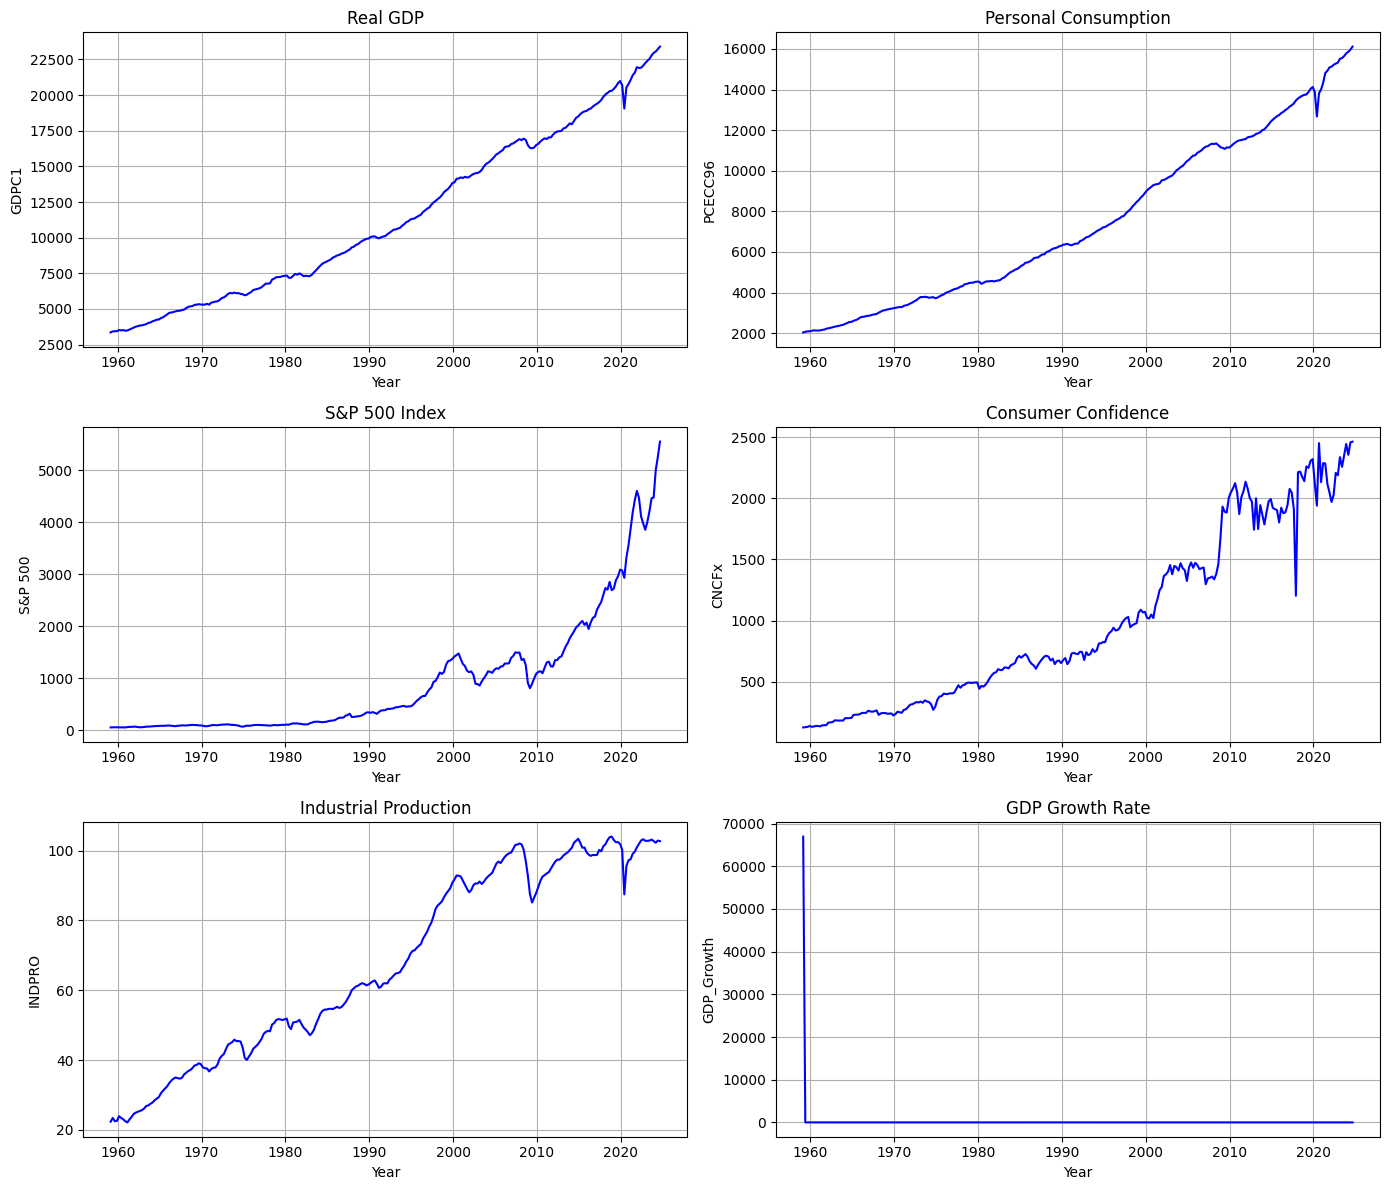

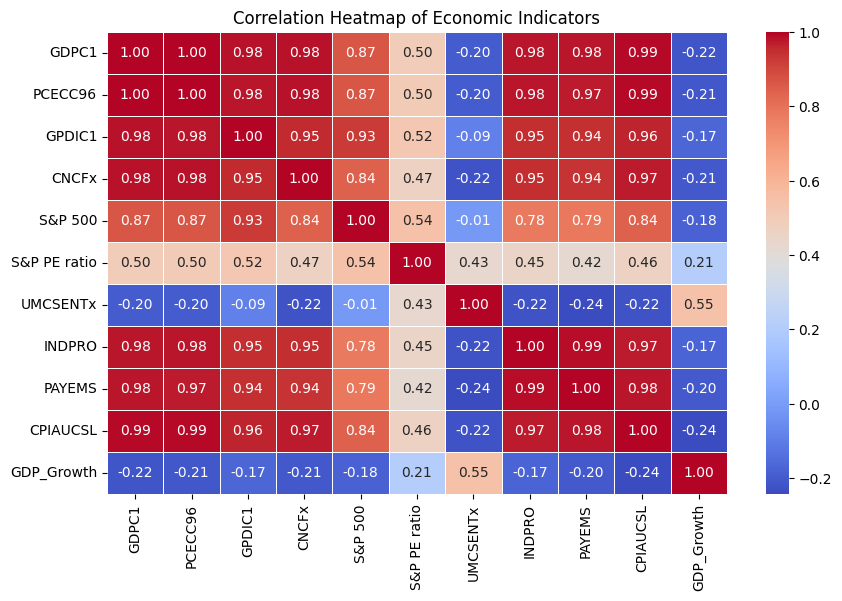

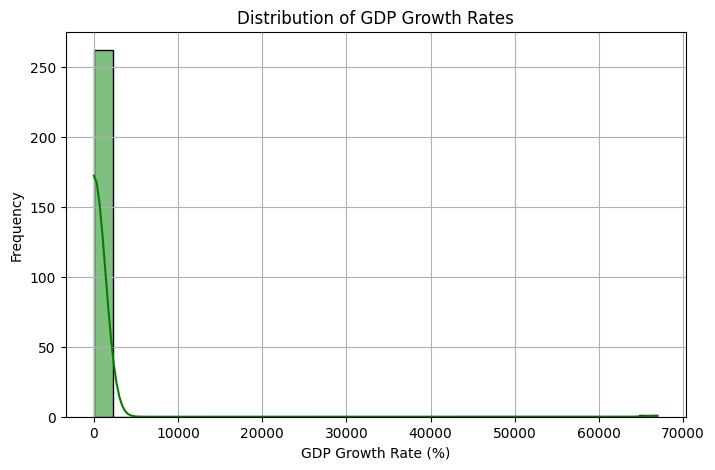

In [29]:
# Time Series Trends for Key Economic Indicators
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Select important features for visualization
key_features = ["GDPC1", "PCECC96", "S&P 500", "CNCFx", "INDPRO", "GDP_Growth"]
titles = ["Real GDP", "Personal Consumption", "S&P 500 Index", "Consumer Confidence", "Industrial Production", "GDP Growth Rate"]

# Convert sasdate to datetime format for proper plotting
quarterly_data_clean["sasdate"] = pd.to_datetime(quarterly_data_clean["sasdate"], errors='coerce')

for i, ax in enumerate(axes.flatten()):
    feature = key_features[i]
    ax.plot(quarterly_data_clean["sasdate"], quarterly_data_clean[feature], label=feature, color='b')
    ax.set_title(titles[i])
    ax.set_xlabel("Year")
    ax.set_ylabel(feature)
    ax.grid(True)

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = X_train_balanced.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Economic Indicators")
plt.show()

# GDP Growth Distribution
plt.figure(figsize=(8, 5))
sns.histplot(quarterly_data_clean["GDP_Growth"], bins=30, kde=True, color="green")
plt.xlabel("GDP Growth Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of GDP Growth Rates")
plt.grid(True)
plt.show()
